### Figuring out Pie plot colors & Losing cells when merging

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import post_patch as pp #post patch script
#post_patch_column = 'postPatch_label'
#post_patch_pipette_column = 'endPipetteR_label'

#sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set(style = "whitegrid")
sns.set_context('notebook')

In [82]:
def get_json_df():
    """Returns a dataframe containing relevant metadata from the JEM forms
    
    Returns
    -------
    json_df : pandas dataframe
    """
    
    json_df = pd.read_csv('C:/users/kumar/documents/github/personal-projects/csv/json_metadata.csv')
    json_df = json_df[json_df['status'] == 'SUCCESS']
    
    #Creates patch_duration column and outputs in minutes
    json_df['patch_duration'] = pd.to_datetime(json_df['extraction.timeRetractionEnd']) - pd.to_datetime(json_df['recording.timeWholeCellStart'])
    json_df['patch_duration'] = (json_df['patch_duration'].astype('timedelta64[s]'))/60
    
    json_df['date'] = json_df['date'].str[:10] #Strip away the time
    json_df['date'] = pd.to_datetime(json_df['date']) #Converting to YYYY-MM-DD
    json_df.set_index('date', inplace = True)
    
    json_df = pp.postpatch_reclass(json_df) #Makes post patch column with the script
    json_df.sort_index(inplace = True) #Sort the date column just in case
    
    json_df.dropna(subset = ['patch_container'], inplace = True)
    json_df = json_df[json_df['patch_container'].str.match('P9')]
    
    json_df = json_df[['roi_major',
                       'roi_minor',
                       'recording.humanCellTypePrediction',
                       'patch_duration',
                       'post_patch',
                       'patch_container']]
    return json_df

#ROI major and minor better to use than approach.manualROI
#Problem: Human data starts around 12/05/17 but there should be some before it

In [83]:
#Making global variables
json_df = get_json_df()

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [84]:
json_df.tail()

,roi_major,roi_minor,recording.humanCellTypePrediction,patch_duration,post_patch,patch_container
date,,,,,,
2018-08-09,VISp,layer 2/3,NaN,3.650000,Nuc-high seal,P9S4_180809_406_A01
2018-08-09,VISp,layer 5,NaN,6.566667,Nuc-high seal,P9S4_180809_404_A01
2018-08-09,VISp,layer 2/3,NaN,5.733333,Nuc-high seal,P9S4_180809_403_A01
2018-08-09,VISp,layer 1,NaN,10.066667,Nuc-low seal,P9S4_180809_402_A01
2018-08-09,VISp,layer 6b,NaN,7.250000,Nuc-high seal,P9S4_180809_405_A01


# Pie Chart

In [85]:
json_df['post_patch'].value_counts()

Nuc-high seal    555
No-high seal     143
No-low seal      109
Nuc-low seal      91
Entire cell        9
Name: post_patch, dtype: int64

In [86]:
def pie_plot(df):    
    df1 = df.groupby(['post_patch']).size().reset_index(name = 'count')
    df1.set_index('post_patch', inplace = True)

    plt.figure(3)
    colors = ['#f7fcb9','#fc9272', '#de2d26', '#31a354', '#a1d99b']
    #Entire(Yellow), No-high(Light Red), No-low(Red), Nuc-high(Green), Nuc-low(Light Green)
    #explode = (0.05, 0.05, 0.05, 0.05, 0.05) #splits the categories
    
    df1.plot.pie(y = 'count', autopct='%1.1f%%', figsize = (8,8), colors = colors, shadow = True, legend = False) 
    plt.axes().set_ylabel('')

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

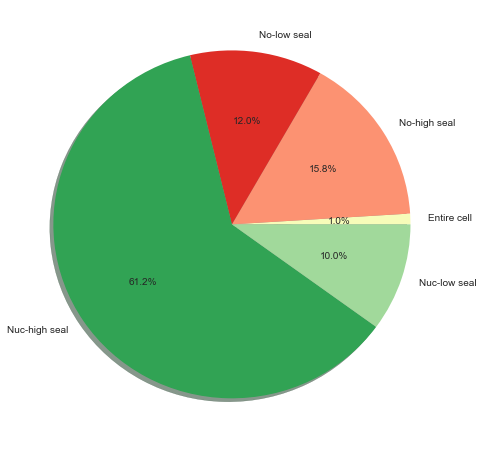

In [87]:
pie_plot(json_df)

# Horizontal Bar Graph with Counts 

In [88]:
def bar_plot(df):    
    df1 = df.groupby(['post_patch']).size().reset_index(name = 'count')
    
    colors = ['#31a354', '#a1d99b', '#fc9272', '#de2d26', '#f7fcb9']
    bp = sns.barplot(x = 'count', y = 'post_patch', 
                     order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell'],
                     palette = colors, saturation = 1, data = df1)
    bp.set(xlabel = 'Count', ylabel = 'Post Patch Outcomes')

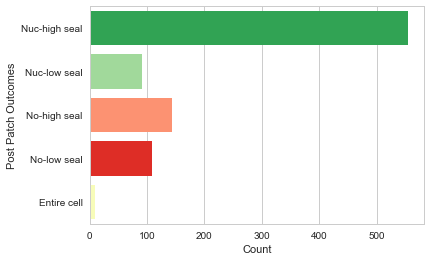

In [89]:
bar_plot(json_df)